In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# PyTorch and Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.optim as optim

# PIL for image handling
from PIL import Image
import cv2
import glob
import joblib
import json
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download and Extract Dataset
dataset_url = "https://crisisnlp.qcri.org/data/crisismmd/CrisisMMD_v2.0.tar.gz"
!wget $dataset_url -O CrisisMMD_v2.0.tar.gz

import tarfile
with tarfile.open("CrisisMMD_v2.0.tar.gz", "r:gz") as tar:
    tar.extractall("CrisisMMD_v2")


--2025-04-18 09:59:21--  https://crisisnlp.qcri.org/data/crisismmd/CrisisMMD_v2.0.tar.gz
Resolving crisisnlp.qcri.org (crisisnlp.qcri.org)... 37.186.61.208
Connecting to crisisnlp.qcri.org (crisisnlp.qcri.org)|37.186.61.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1902053684 (1.8G) [application/x-gzip]
Saving to: ‘CrisisMMD_v2.0.tar.gz’

CrisisMMD_v2.0.tar. 100%[===================>]   1.77G  21.7MB/s    in 84s     

2025-04-18 10:00:45 (21.7 MB/s) - ‘CrisisMMD_v2.0.tar.gz’ saved [1902053684/1902053684]



In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Step 1: Unzip the dataset
zip_path = "/content/CrisisMMD_v2/CrisisMMD_v2.0/crisismmd_datasplit_all.zip"
extract_path = "/content/CrisisMMD_v2/CrisisMMD_v2.0"
os.makedirs(extract_path, exist_ok=True)

In [ ]:
# Extract only required files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if any(tsv in file for tsv in ["task_humanitarian_text_img_train.tsv", "task_humanitarian_text_img_test.tsv", "task_humanitarian_text_img_dev.tsv"]):
            zip_ref.extract(file, extract_path)

print("TSV files extracted successfully!")

TSV files extracted successfully!


In [ ]:
# Step 2: Load the dataset
train_file = os.path.join("/content/CrisisMMD_v2/CrisisMMD_v2.0/crisismmd_datasplit_all/task_humanitarian_text_img_train.tsv")
test_file = os.path.join("/content/CrisisMMD_v2/CrisisMMD_v2.0/crisismmd_datasplit_all/task_humanitarian_text_img_test.tsv")
dev_file = os.path.join("/content/CrisisMMD_v2/CrisisMMD_v2.0/crisismmd_datasplit_all/task_humanitarian_text_img_dev.tsv")

train_data = pd.read_csv(train_file, sep="\t")
test_data = pd.read_csv(test_file, sep="\t")
dev_data = pd.read_csv(dev_file, sep="\t")


In [ ]:
# Combine data
data_df = pd.concat([train_data, test_data, dev_data], ignore_index=True)
print(f"Dataset loaded! Shape: {data_df.shape}")


Dataset loaded! Shape: (18082, 9)


In [ ]:
print(data_df.columns)

Index(['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image', 'label',
       'label_text', 'label_image', 'label_text_image'],
      dtype='object')


In [ ]:
data_df.head(10)

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_humanitarian,other_relevant_information,not_humanitarian,Negative
1,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,infrastructure_and_utility_damage,Negative
2,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
3,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
4,california_wildfires,917793137925459968,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
5,california_wildfires,917815040962695168,917815040962695168_1,RT @TheAtlantic: Photos of California's destru...,data_image/california_wildfires/10_10_2017/917...,vehicle_damage,infrastructure_and_utility_damage,vehicle_damage,Negative
6,california_wildfires,917815040962695168,917815040962695168_0,RT @TheAtlantic: Photos of California's destru...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,rescue_volunteering_or_donation_effort,Negative
7,california_wildfires,917815040962695168,917815040962695168_2,RT @TheAtlantic: Photos of California's destru...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
8,california_wildfires,917828283047260161,917828283047260161_0,Why California's #wildfires are worse in the f...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,other_relevant_information,Positive
9,california_wildfires,917828283047260161,917828283047260161_1,Why California's #wildfires are worse in the f...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,other_relevant_information,Positive


In [ ]:
from sklearn.utils import resample

# Get the largest class count
max_class_size = data_df["label"].value_counts().max()

# Upsample all minority classes
balanced_data = []
for label in data_df["label"].unique():
    class_subset = data_df[data_df["label"] == label]

    if len(class_subset) < max_class_size:
        class_subset = resample(class_subset,
                                replace=True,
                                n_samples=max_class_size,
                                random_state=42)

    balanced_data.append(class_subset)

# Combine the resampled data
data_df_balanced = pd.concat(balanced_data)

# Shuffle dataset
data_df = data_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"New dataset shape: {data_df_balanced.shape}")

New dataset shape: (55984, 9)


In [ ]:
# Label encoding
label_encoder = LabelEncoder()
data_df["label_encoded"] = label_encoder.fit_transform(data_df["label"])


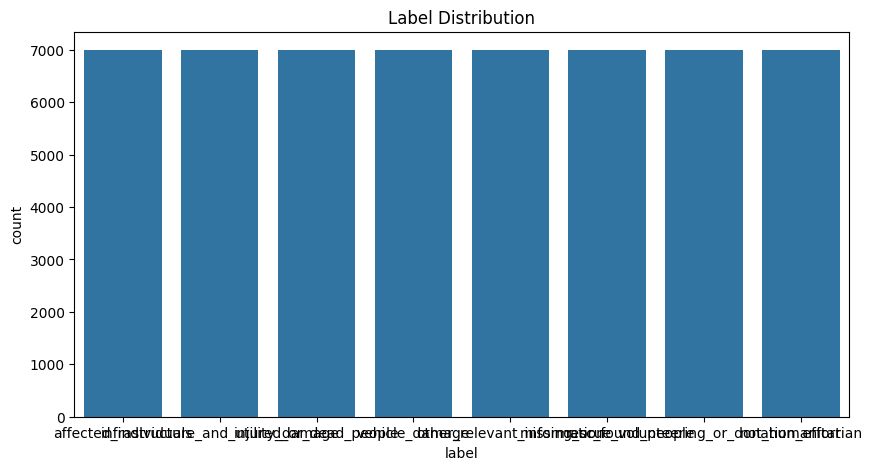

In [ ]:
# 2. Perform EDA
# Check label distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=data_df, x="label", order=data_df["label"].value_counts().index)
plt.title("Label Distribution")
plt.show()


In [ ]:
# Text preprocessing
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

def preprocess_text(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt"
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

In [ ]:
# Image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Custom Dataset Class
class CrisisDataset(Dataset):
    def __init__(self, df, tokenizer, transform, images_dir):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.images_dir = images_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["tweet_text"]
        text_inputs = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors="pt")

        img_path = os.path.join(self.images_dir, row["image"])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        label = torch.tensor(row["label_encoded"], dtype=torch.long)
        return text_inputs, img, label

In [ ]:
def custom_collate_fn(batch):
    texts, images, labels = zip(*batch)
    input_ids = [text["input_ids"].squeeze(0) for text in texts]
    attention_masks = [text["attention_mask"].squeeze(0) for text in texts]

    input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)

    images = torch.stack(images, dim=0)
    # The original error was likely due to labels not being converted to a tensor correctly or having the wrong shape.
    # This change ensures they are a tensor of the correct type, shape, and are on the correct device.
    labels = torch.tensor(labels, dtype=torch.long, device=device) # Changed this line to create tensor directly on the device and ensure labels have the correct shape
    labels = labels.view(-1)  # Reshape labels to be 1-dimensional

    return {"input_ids": input_ids_padded, "attention_mask": attention_masks_padded}, images, labels

In [ ]:
SEED = 42
train_data, val_data = train_test_split(data_df, test_size=0.2, stratify=data_df["label_encoded"], random_state=SEED)


In [ ]:
train_dataset = CrisisDataset(train_data, tokenizer, image_transform, extract_path)
val_dataset = CrisisDataset(val_data, tokenizer, image_transform, extract_path)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)


In [ ]:
# Multimodal Model with Frozen Pretrained Weights
class MultimodalModel(nn.Module):
    def __init__(self, text_model_name="microsoft/deberta-v3-base"):
        super(MultimodalModel, self).__init__()

        # Load DeBERTa model and freeze its parameters
        self.text_model = AutoModel.from_pretrained(text_model_name)
        for param in self.text_model.parameters():
            param.requires_grad = False
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 256)

        # Load ResNet-50 and freeze its feature extractor
        self.image_model = models.resnet50(pretrained=True)
        for param in self.image_model.parameters():
            param.requires_grad = False
        # Replace the classifier head (unfrozen by default)
        self.image_model.fc = nn.Linear(self.image_model.fc.in_features, 256)

        # Classifier for multimodal fusion
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 8)
        )

    def forward(self, text_inputs, images):
        text_outputs = self.text_model(**text_inputs)
        text_features = torch.mean(text_outputs.last_hidden_state, dim=1)
        text_features = self.text_fc(text_features)

        image_features = self.image_model(images)
        combined_features = torch.cat((text_features, image_features), dim=1)
        return self.classifier(combined_features)


In [ ]:
# Training Setup
model = MultimodalModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Updated Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0.0
    best_model_weights = None

    os.makedirs("saved_models", exist_ok=True)

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train = 0, 0
        all_train_preds, all_train_labels = [], []

        for text_inputs, images, labels in train_loader:
            text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(text_inputs, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_acc = correct_train / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct_val = 0, 0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for text_inputs, images, labels in val_loader:
                text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
                images, labels = images.to(device), labels.to(device)

                outputs = model(text_inputs, images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct_val += (preds == labels).sum().item()
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = correct_val / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict().copy()
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_weights,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_acc
            }, f"saved_models/best_model_epoch_{epoch+1}.pth")
            print(f"New best model saved with val acc: {val_acc:.4f}")

    # Load best weights back into model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # Save final artifacts
    final_dir = "/content/drive/MyDrive/Multimodel"
    os.makedirs(final_dir, exist_ok=True)

    torch.save(model.state_dict(), os.path.join(final_dir, "final_model_state_dict.pth"))
    torch.save(optimizer.state_dict(), os.path.join(final_dir, "optimizer_state_dict.pth"))
    joblib.dump(label_encoder, os.path.join(final_dir, "label_encoder.pkl"))

    metadata = {
        "tokenizer": "microsoft/deberta-v3-base",
        "image_model": "resnet50",
        "num_classes": len(label_encoder.classes_),
        "input_size": 224
    }

    with open(os.path.join(final_dir, "metadata.json"), "w") as f:
        json.dump(metadata, f)

    print("\nFinal model, optimizer, label encoder, and metadata saved to:", final_dir)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Start Training
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=5
)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
Train - Loss: 1.3970, Acc: 0.4987
Val   - Loss: 1.1799, Acc: 0.5807
New best model saved with val acc: 0.5807
Epoch 2/5
Train - Loss: 1.1221, Acc: 0.5987
Val   - Loss: 1.0541, Acc: 0.6125
New best model saved with val acc: 0.6125
Epoch 3/5
Train - Loss: 1.0153, Acc: 0.6334
Val   - Loss: 1.0287, Acc: 0.6136
New best model saved with val acc: 0.6136
Epoch 4/5
Train - Loss: 0.9338, Acc: 0.6625
Val   - Loss: 0.9276, Acc: 0.6647
New best model saved with val acc: 0.6647
Epoch 5/5
Train - Loss: 0.8694, Acc: 0.6851
Val   - Loss: 0.9518, Acc: 0.6523

Final model, optimizer, label encoder, and metadata saved to: /content/drive/MyDrive/Multimodel


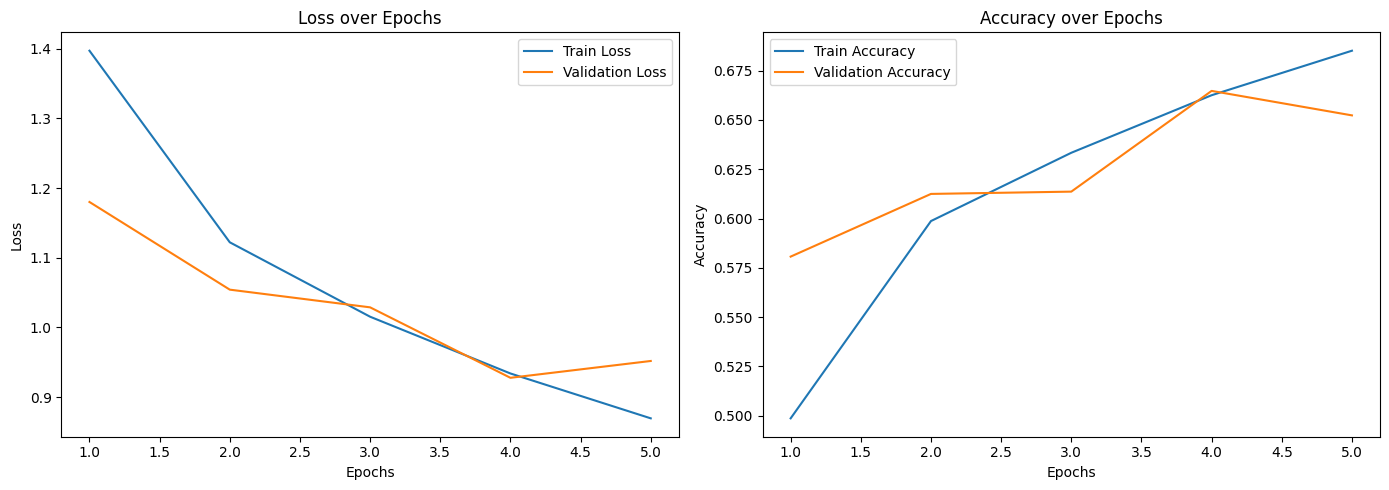

In [ ]:
# Plot Training and Validation Accuracy and Loss
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Classification Report:
                                        precision    recall  f1-score   support

                  affected_individuals       0.63      0.59      0.61      1399
     infrastructure_and_utility_damage       0.59      0.32      0.41      1399
                injured_or_dead_people       0.53      0.99      0.69      1400
               missing_or_found_people       0.95      1.00      0.97      1400
                      not_humanitarian       0.68      0.36      0.47      1400
            other_relevant_information       0.76      0.34      0.47      1399
rescue_volunteering_or_donation_effort       0.44      0.71      0.54      1400
                        vehicle_damage       0.90      0.93      0.91      1400

                              accuracy                           0.65     11197
                             macro avg       0.68      0.65      0.63     11197
                          weighted avg       0.68      0.65      0.63     11197

Confusion Matr

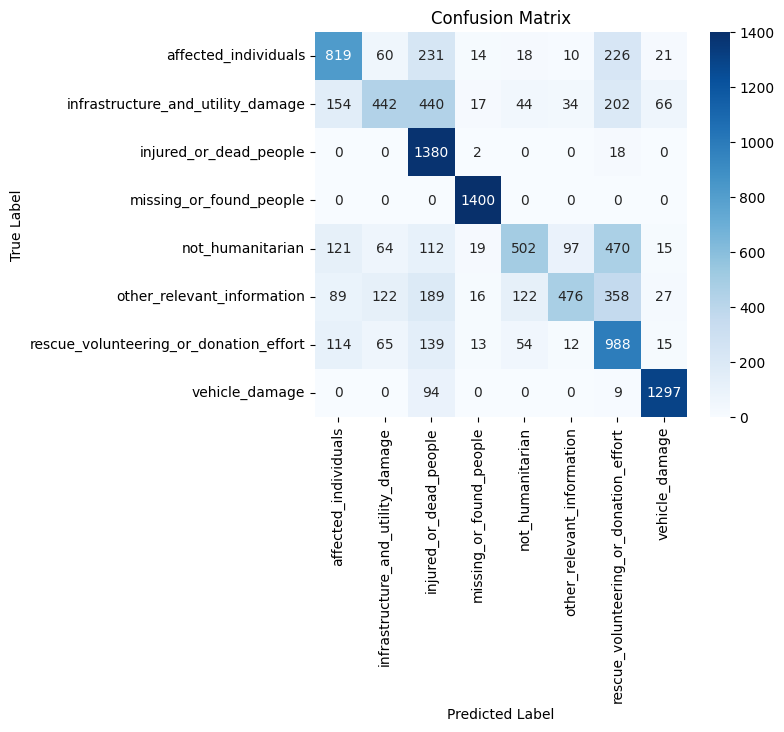

In [ ]:
# Evaluation Function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for text_inputs, images, labels in data_loader:
            text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
            images, labels = images.to(device), labels.to(device)

            outputs = model(text_inputs, images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the model
evaluate_model(model, val_loader)

# Testing part

In [ ]:
import os
import zipfile
import tarfile
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import joblib
import json

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Download and extract dataset
dataset_url = "https://crisisnlp.qcri.org/data/crisismmd/CrisisMMD_v2.0.tar.gz"
os.system(f"wget {dataset_url} -O CrisisMMD_v2.0.tar.gz")

with tarfile.open("CrisisMMD_v2.0.tar.gz", "r:gz") as tar:
    tar.extractall("CrisisMMD_v2")



EOFError: Compressed file ended before the end-of-stream marker was reached

In [ ]:
zip_path = "CrisisMMD_v2/CrisisMMD_v2.0/crisismmd_datasplit_all.zip"
extract_path = "CrisisMMD_v2/CrisisMMD_v2.0"


In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if "task_informative_text_img_test.tsv" in file:
            zip_ref.extract(file, extract_path)

test_file = os.path.join(extract_path, "crisismmd_datasplit_all/task_informative_text_img_test.tsv")
test_data = pd.read_csv(test_file, sep="\t")

In [ ]:
# Load metadata and label encoder
label_encoder = joblib.load("/content/drive/MyDrive/Multimodel/label_encoder.pkl")
with open("/content/drive/MyDrive/Multimodel/metadata.json") as f:
    metadata = json.load(f)

In [ ]:
# Transform labels
test_data["label_encoded"] = label_encoder.transform(test_data["label"])


In [ ]:
# Tokenizer and image transforms
tokenizer = AutoTokenizer.from_pretrained(metadata["tokenizer"])
image_transform = transforms.Compose([
    transforms.Resize((metadata["input_size"], metadata["input_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Dataset definition
class CrisisDataset(Dataset):
    def __init__(self, df, tokenizer, transform, images_dir):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.images_dir = images_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text_inputs = self.tokenizer(row["tweet_text"], truncation=True, padding='max_length', max_length=128, return_tensors="pt")
        img_path = os.path.join(self.images_dir, row["image"])
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.new("RGB", (224, 224))
        img = self.transform(img)
        label = torch.tensor(row["label_encoded"], dtype=torch.long)
        return text_inputs, img, label

def custom_collate_fn(batch):
    texts, images, labels = zip(*batch)
    input_ids = [text["input_ids"].squeeze(0) for text in texts]
    attention_masks = [text["attention_mask"].squeeze(0) for text in texts]

    input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)

    return {"input_ids": input_ids_padded, "attention_mask": attention_masks_padded}, images, labels


In [ ]:
# Multimodal Model with Frozen Pretrained Weights
class MultimodalModel(nn.Module):
    def __init__(self, text_model_name="microsoft/deberta-v3-base"):
        super(MultimodalModel, self).__init__()

        # Load DeBERTa model and freeze its parameters
        self.text_model = AutoModel.from_pretrained(text_model_name)
        for param in self.text_model.parameters():
            param.requires_grad = False
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 256)

        # Load ResNet-50 and freeze its feature extractor
        self.image_model = models.resnet50(pretrained=True)
        for param in self.image_model.parameters():
            param.requires_grad = False
        # Replace the classifier head (unfrozen by default)
        self.image_model.fc = nn.Linear(self.image_model.fc.in_features, 256)

        # Classifier for multimodal fusion
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 8)
        )

    def forward(self, text_inputs, images):
        text_outputs = self.text_model(**text_inputs)
        text_features = torch.mean(text_outputs.last_hidden_state, dim=1)
        text_features = self.text_fc(text_features)

        image_features = self.image_model(images)
        combined_features = torch.cat((text_features, image_features), dim=1)
        return self.classifier(combined_features)


In [ ]:
# Load the model and weights
model = MultimodalModel().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Multimodel/final_model_state_dict.pth", map_location=device))
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalModel(
  (text_model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

In [ ]:
# Dataloader
images_dir = extract_path
test_dataset = CrisisDataset(test_data, tokenizer, image_transform, images_dir)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)


Classification Report:
                                        precision    recall  f1-score   support

                  affected_individuals       0.23      0.67      0.35        86
     infrastructure_and_utility_damage       0.56      0.35      0.44       319
                injured_or_dead_people       0.11      0.95      0.20        41
               missing_or_found_people       0.14      1.00      0.25         5
                      not_humanitarian       0.79      0.33      0.47       849
            other_relevant_information       0.78      0.35      0.48       578
rescue_volunteering_or_donation_effort       0.32      0.69      0.44       340
                        vehicle_damage       0.35      1.00      0.51        19

                              accuracy                           0.43      2237
                             macro avg       0.41      0.67      0.39      2237
                          weighted avg       0.64      0.43      0.45      2237



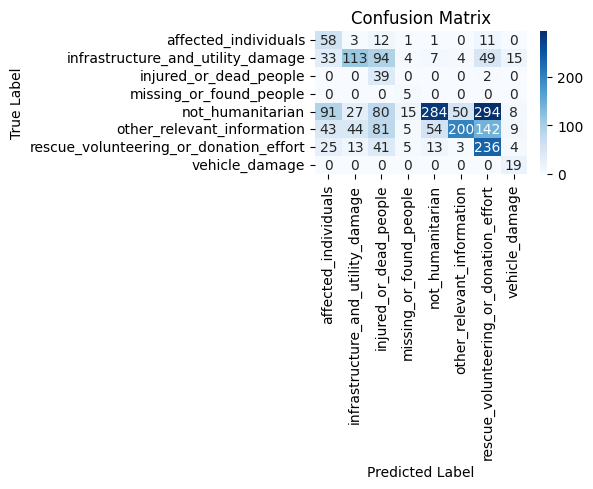

In [ ]:
# Evaluation
all_preds, all_labels = [], []
with torch.no_grad():
    for text_inputs, images, labels in test_loader:
        text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
        images, labels = images.to(device), labels.to(device)
        outputs = model(text_inputs, images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()